# CPSC 440 Project

## Imports

In [17]:
import polars as pl
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob
import numpy as np
import pandas as pd
import lightgbm as lgb
from scipy.sparse import hstack
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin

ROOT = '/kaggle/input/home-credit-credit-risk-model-stability'

In [2]:
class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns: 
                if col.endswith("D"):
                    # Calculate the difference in days between each date column and date_decision
                    df = df.with_columns(
                        (pl.col("date_decision") - pl.col(col)).dt.total_days().alias(col)
                    )
                    df = df.with_columns(pl.col(col).fill_null(np.nan)) 
        # Drop date_decision column
        df = df.drop("date_decision")

        return df
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.8:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        
        return df



class Aggregator:
    # Please add or subtract features yourself, be aware that too many features will take up too much space.
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        # expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        expr_median = [pl.median(col).alias(f"median_{col}") for col in cols]
        expr_var = [pl.var(col).alias(f"var_{col}") for col in cols]

        return expr_max + expr_last + expr_mean 

    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        # expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        
        return expr_max 

    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        # expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        # expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        # expr_count = [pl.count(col).alias(f"count_{col}") for col in cols]
        return expr_max + expr_last  # +expr_count

    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        # expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        return expr_max

    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        # expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        # expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return expr_max + expr_last

    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.set_table_dtypes)
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                try:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
                except:
                    continue
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Train data

In [3]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")

TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [4]:
%%time
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        read_file(TRAIN_DIR / "train_applprev_2.parquet", 2),
        read_file(TRAIN_DIR / "train_person_2.parquet", 2)
    ]
}

CPU times: user 4min 40s, sys: 1min 37s, total: 6min 18s
Wall time: 2min 13s


## Data Processing

In [5]:

df_train = feature_eng(**data_store) 
print("train data shape:\t", df_train.shape)
gc.collect()
df_train = df_train.pipe(Pipeline.filter_cols) 
gc.collect()
df_train, cat_cols = to_pandas(df_train) 
gc.collect()
df_train = reduce_mem_usage(df_train) 
gc.collect()
print("train data shape:\t", df_train.shape)
nums=df_train.select_dtypes(exclude='category').columns

from itertools import combinations, permutations

nans_df = df_train[nums].isna()
nans_groups={}
for col in nums:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

def reduce_group(grps):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = df_train[gg].nunique()
            if n>mx:
                mx = n
                vx = gg
        use.append(vx)
        #print()
    print('Use these',use)
    return use

def group_columns_by_correlation(matrix, threshold=0.8):
    correlation_matrix = matrix.corr()
    groups = []
    remaining_cols = list(matrix.columns)
    while remaining_cols:
        col = remaining_cols.pop(0)
        group = [col]
        correlated_cols = [col]
        for c in remaining_cols:
            if correlation_matrix.loc[col, c] >= threshold:
                group.append(c)
                correlated_cols.append(c)
        groups.append(group)
        remaining_cols = [c for c in remaining_cols if c not in correlated_cols]
    return groups

uses=[]
for k,v in nans_groups.items():
    if len(v)>1:
            Vs = nans_groups[k]
            grps= group_columns_by_correlation(df_train[Vs], threshold=0.8)
            use=reduce_group(grps)
            uses=uses+use
    else:
        uses=uses+v
    print('####### NAN count =',k)
print(uses)
print(len(uses))
uses=uses+list(df_train.select_dtypes(include='category').columns)
print(len(uses))
df_train=df_train[uses]

train data shape:	 (1526659, 712)
Memory usage of dataframe is 4190.26 MB
Memory usage after optimization is: 1504.06 MB
Decreased by 64.1%
train data shape:	 (1526659, 451)
Use these ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision', 'credamount_770A', 'applicationcnt_361L', 'applications30d_658L', 'applicationscnt_1086L', 'applicationscnt_464L', 'applicationscnt_867L', 'clientscnt_1022L', 'clientscnt_100L', 'clientscnt_1071L', 'clientscnt_1130L', 'clientscnt_157L', 'clientscnt_257L', 'clientscnt_304L', 'clientscnt_360L', 'clientscnt_493L', 'clientscnt_533L', 'clientscnt_887L', 'clientscnt_946L', 'deferredmnthsnum_166L', 'disbursedcredamount_1113A', 'downpmt_116A', 'homephncnt_628L', 'isbidproduct_1095L', 'mobilephncnt_593L', 'numactivecreds_622L', 'numactivecredschannel_414L', 'numactiverelcontr_750L', 'numcontrs3months_479L', 'numnotactivated_1143L', 'numpmtchanneldd_318L', 'numrejects9m_859L', 'sellerplacecnt_915L', 'max_mainoccupationinc_384A', 'max_birth_259D

In [6]:
df_train

,case_id,WEEK_NUM,target,month_decision,weekday_decision,credamount_770A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,...,last_subjectroles_name_838M,max_cacccardblochreas_147M,last_cacccardblochreas_147M,max_conts_type_509L,max_conts_role_79M,max_empls_economicalst_849M,max_empls_employer_name_740M,last_conts_role_79M,last_empls_economicalst_849M,last_empls_employer_name_740M
0,0,0,0,1,4,30000.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,1,4,19999.800781,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,1,5,78000.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,PRIMARY_MOBILE,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0,1,4,40000.000000,0.0,1.0,0.0,2.0,...,NaN,NaN,NaN,PRIMARY_MOBILE,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,1,1,5,44000.000000,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,PRIMARY_MOBILE,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,91,0,10,1,30000.000000,0.0,0.0,0.0,0.0,...,a55475b1,a55475b1,a55475b1,PRIMARY_MOBILE,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
1526655,2703451,91,0,10,1,100000.000000,0.0,0.0,5.0,0.0,...,a55475b1,a55475b1,a55475b1,PRIMARY_MOBILE,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
1526656,2703452,91,0,10,1,60000.000000,0.0,0.0,0.0,0.0,...,a55475b1,a55475b1,a55475b1,PRIMARY_MOBILE,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
1526657,2703453,91,0,10,1,6000.000000,0.0,0.0,36.0,0.0,...,a55475b1,a55475b1,a55475b1,PRIMARY_MOBILE,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1


## Feature Selection

In [7]:
y = df_train["target"]
weeks = df_train["WEEK_NUM"]
df_train= df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

In [8]:
df_train[cat_cols] = df_train[cat_cols].astype(str)
import polars as pl
from sklearn.preprocessing import OrdinalEncoder


# Fit Ordinal Encoder on Training Data
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
encoder.fit(df_train[cat_cols])

# Transform Training Data
df_train[cat_cols] = encoder.transform(df_train[cat_cols])
df_train[cat_cols] = df_train[cat_cols].fillna(-1)
df_train[cat_cols] = df_train[cat_cols].astype(int)


In [9]:


params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,  
    "learning_rate": 0.05,
    "n_estimators": 2000,  
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "reg_alpha": 0.1,
    "reg_lambda": 10,
    "extra_trees":True,
    'num_leaves':64,
    "device": "gpu", 
    "verbose": -1,
}


# rf_params = {
#     "n_estimators": 100,  # Number of trees in the forest
#     "criterion": "gini",  # Criteria for splitting: either "gini" or "entropy"
#     "max_depth": None,  # Maximum depth of the tree. None means unlimited depth.
#     "min_samples_split": 2,  # Minimum number of samples required to split an internal node
#     "min_samples_leaf": 1,  # Minimum number of samples required to be at a leaf node
#     "max_features": "auto",  # Number of features to consider when looking for the best split
#     "bootstrap": True,  # Whether bootstrap samples are used when building trees
#     "random_state": 42,  # Seed for random number generator
#     "n_jobs": -1,  # Number of jobs to run in parallel (-1 means using all processors)
#     "verbose": 0,  # Controls the verbosity when fitting and predicting
# }

In [10]:
df_train[cat_cols] = df_train[cat_cols].fillna(0)
# df_train[cat_cols].to_csv('catcol.csv')

In [11]:
fitted_models = []
cv_scores = []
cv = StratifiedGroupKFold(n_splits=5, shuffle=False)
for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
    
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set = [(X_valid, y_valid)],
        callbacks = [lgb.log_evaluation(200), lgb.early_stopping(100)] )
    fitted_models.append(model)
    
    y_pred_valid = model.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)
    
print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.847466
[400]	valid_0's auc: 0.852819
[600]	valid_0's auc: 0.854459
[800]	valid_0's auc: 0.855006
[1000]	valid_0's auc: 0.855353
[1200]	valid_0's auc: 0.855473
Early stopping, best iteration is:
[1295]	valid_0's auc: 0.855529
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.846845
[400]	valid_0's auc: 0.852222
[600]	valid_0's auc: 0.853989
[800]	valid_0's auc: 0.854627
[1000]	valid_0's auc: 0.855144
[1200]	valid_0's auc: 0.855315
Early stopping, best iteration is:
[1237]	valid_0's auc: 0.855348
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.851917
[400]	valid_0's auc: 0.857664
[600]	valid_0's auc: 0.859452
[800]	valid_0's auc: 0.860114
[1000]	valid_0's auc: 0.860467
[1200]	valid_0's auc: 0.860704
Early stopping, best iteration is:
[1276]	valid_0's auc: 0.860837
Training until validation scores don't improve for 100 rounds
[200]	va

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

# Initialize confusion matrix and classification report variables
conf_matrix = None
class_report = None

# Predict labels for validation data
y_pred_labels = model.predict(X_valid)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_valid, y_pred_labels)

# Compute classification report
class_report = classification_report(y_valid, y_pred_labels)

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[295320    153]
 [  9263    183]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    295473
           1       0.54      0.02      0.04      9446

    accuracy                           0.97    304919
   macro avg       0.76      0.51      0.51    304919
weighted avg       0.96      0.97      0.95    304919



In [15]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

model = VotingModel(fitted_models)

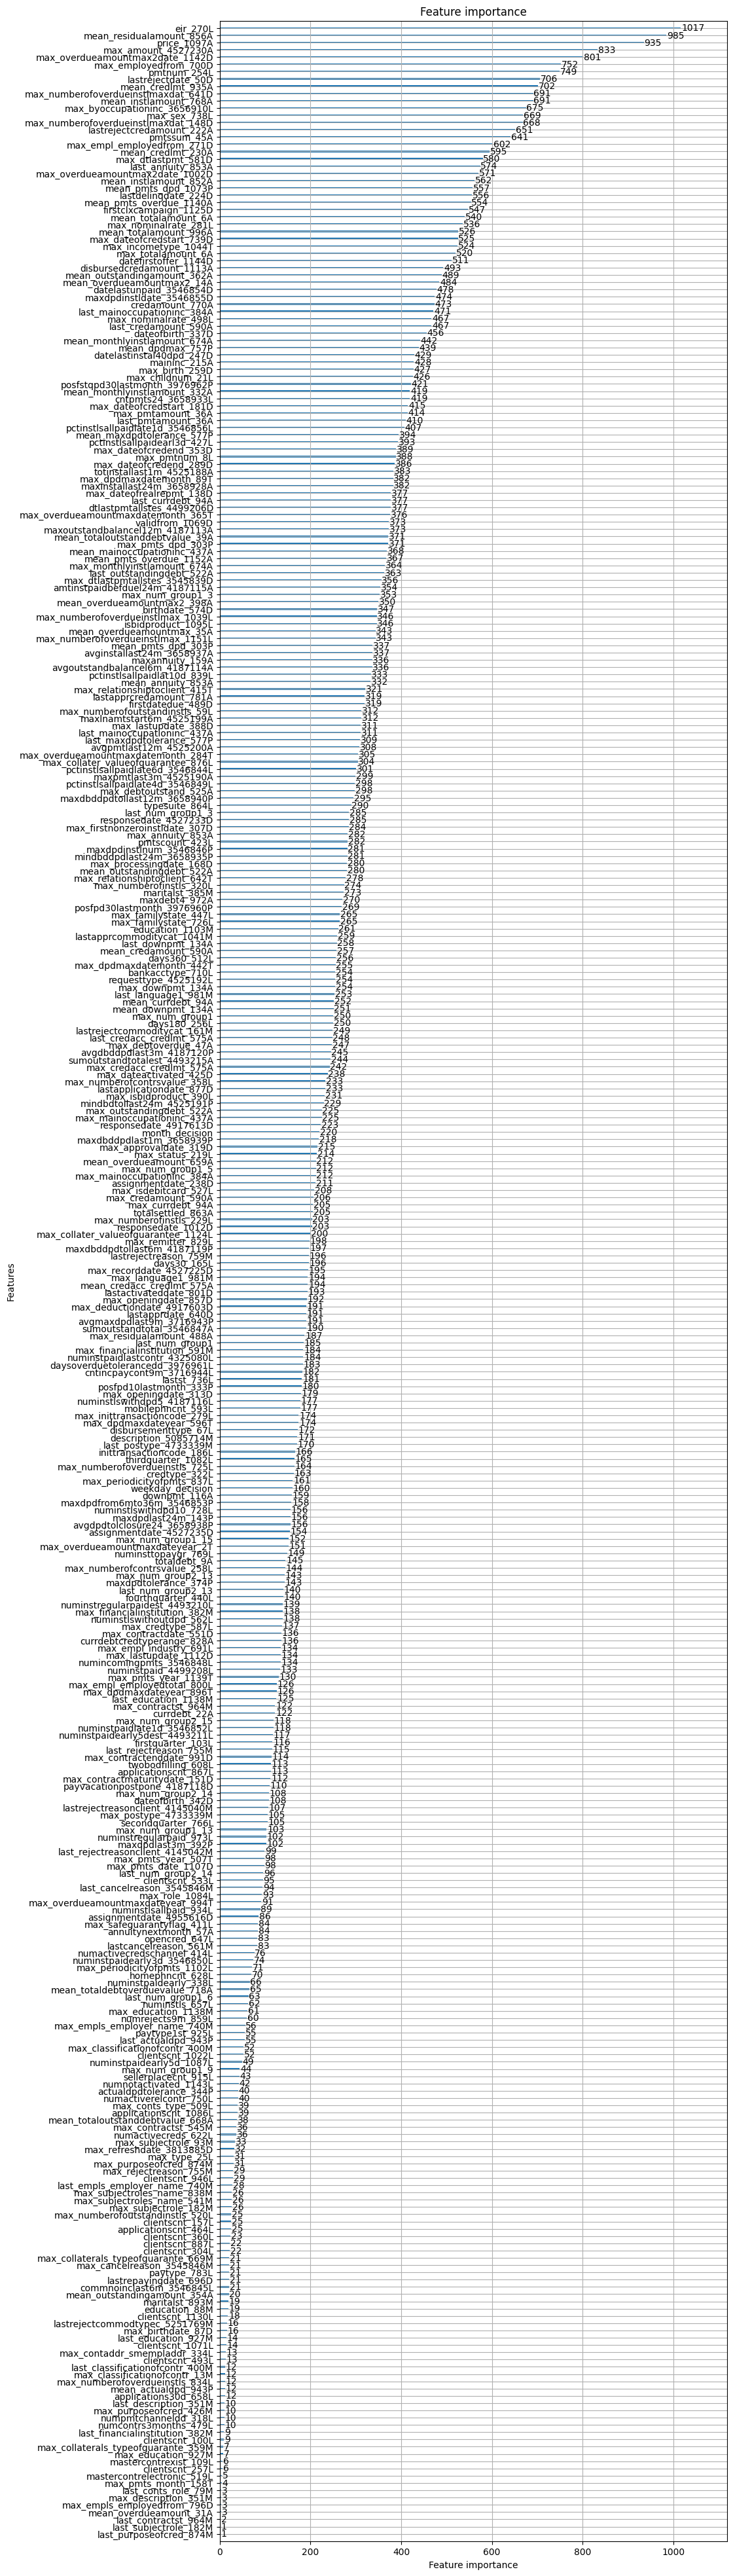

In [18]:
lgb.plot_importance(fitted_models[2], importance_type="split", figsize=(10,50))
plt.show()

In [19]:
features = X_train.columns
importances = fitted_models[2].feature_importances_
feature_importance = pd.DataFrame({'importance':importances,'features':features}).sort_values('importance', ascending=False).reset_index(drop=True)
feature_importance

,importance,features
0,1017,eir_270L
1,985,mean_residualamount_856A
2,935,price_1097A
3,833,max_amount_4527230A
4,801,max_overdueamountmax2date_1142D
...,...,...
368,0,max_empladdr_zipcode_114M
369,0,last_empladdr_district_926M
370,0,max_collater_typofvalofguarant_298M
371,0,max_collater_typofvalofguarant_407M


In [23]:
drop_list = []
for i, f in feature_importance.iterrows():
    if f['importance'] < 200:
        drop_list.append(f['features'])
print(f"Number of features which are not important: {len(drop_list)} ")

Number of features which are not important: 206 


In [35]:
feature_importance[:25].features

0                                eir_270L
1                mean_residualamount_856A
2                             price_1097A
3                     max_amount_4527230A
4         max_overdueamountmax2date_1142D
5                   max_employedfrom_700D
6                             pmtnum_254L
7                      lastrejectdate_50D
8                       mean_credlmt_935A
9                   mean_instlamount_768A
10    max_numberofoverdueinstlmaxdat_641D
11           max_byoccupationinc_3656910L
12                           max_sex_738L
13    max_numberofoverdueinstlmaxdat_148D
14              lastrejectcredamount_222A
15                            pmtssum_45A
16             max_empl_employedfrom_271D
17                      mean_credlmt_230A
18                     max_dtlastpmt_581D
19                      last_annuity_853A
20        max_overdueamountmax2date_1002D
21                  mean_instlamount_852A
22                    mean_pmts_dpd_1073P
23                    lastdelinqda

## Test Data

In [37]:
data_store_test = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        read_file(TEST_DIR / "test_applprev_2.parquet", 2),
        read_file(TEST_DIR / "test_person_2.parquet", 2)
    ]
}

In [38]:
df_test = feature_eng(**data_store_test)
print("test data shape:\t", df_test.shape)
print(df_test["case_id"])
gc.collect()
df_test = df_test.select([col for col in df_train.columns if col != "target"] + ['case_id'])
print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)
df_test, cat_cols = to_pandas(df_test, cat_cols)
df_test = df_test.set_index("case_id")
df_test = reduce_mem_usage(df_test)
df_test[cat_cols] = df_test[cat_cols].astype(str)

gc.collect()

test data shape:	 (10, 711)
shape: (10,)
Series: 'case_id' [i64]
[
	57543
	57549
	57551
	57552
	57569
	57630
	57631
	57632
	57633
	57634
]
train data shape:	 (1526659, 373)
test data shape:	 (10, 374)
Memory usage of dataframe is 0.03 MB
Memory usage after optimization is: 0.02 MB
Decreased by 38.9%


0

In [47]:
X_train

,month_decision,weekday_decision,credamount_770A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_867L,clientscnt_1022L,clientscnt_100L,...,last_subjectroles_name_838M,max_cacccardblochreas_147M,last_cacccardblochreas_147M,max_conts_type_509L,max_conts_role_79M,max_empls_economicalst_849M,max_empls_employer_name_740M,last_conts_role_79M,last_empls_economicalst_849M,last_empls_employer_name_740M
0,1,4,30000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,3,7,7,5,6,1,11,6,1
1,1,4,19999.800781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,3,7,7,5,6,1,11,6,1
2,1,5,78000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,3,7,4,5,6,1,11,6,1
3,1,4,40000.000000,0.0,1.0,0.0,2.0,1.0,0.0,0.0,...,1,3,7,4,5,6,1,11,6,1
4,1,5,44000.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1,3,7,4,5,6,1,11,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,10,1,30000.000000,0.0,0.0,0.0,0.0,10.0,0.0,0.0,...,0,2,6,4,4,5,0,10,5,0
1526655,10,1,100000.000000,0.0,0.0,5.0,0.0,5.0,0.0,0.0,...,0,2,6,4,4,5,0,10,5,0
1526656,10,1,60000.000000,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0,2,6,4,4,5,0,10,5,0
1526657,10,1,6000.000000,0.0,0.0,36.0,0.0,9.0,1.0,0.0,...,0,2,6,4,4,5,0,10,5,0


In [40]:
# Transform Test Data using the same encoder instance to ensure consistency
df_test[cat_cols] = encoder.transform(df_test[cat_cols])
df_test[cat_cols] = df_test[cat_cols].fillna(-1)
df_test[cat_cols] = df_test[cat_cols].astype(int)

In [44]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {df_test.shape}")

Train: (1221740, 373)
Valid: (304919, 373)
Test: (10, 373)


## Model Training

In [45]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['category']).columns

In [10]:
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

In [11]:
X_train_numerical = pd.DataFrame(numerical_imputer.fit_transform(X_train[numerical_cols]), columns=numerical_cols)
X_test_numerical = pd.DataFrame(numerical_imputer.transform(X_test[numerical_cols]), columns=numerical_cols)
X_valid_numerical = pd.DataFrame(numerical_imputer.transform(X_valid[numerical_cols]), columns=numerical_cols)

In [12]:
X_train_categorical = pd.DataFrame(categorical_imputer.fit_transform(X_train[categorical_cols]), columns=categorical_cols)
X_test_categorical = pd.DataFrame(categorical_imputer.transform(X_test[categorical_cols]), columns=categorical_cols)
X_valid_categorical = pd.DataFrame(categorical_imputer.transform(X_valid[categorical_cols]), columns=categorical_cols)

In [13]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train_categorical)
X_test_encoded = encoder.transform(X_test_categorical)
X_valid_encoded = encoder.transform(X_valid_categorical)

In [14]:
X_train = hstack([X_train_numerical, X_train_encoded])
X_test = hstack([X_test_numerical, X_test_encoded])
X_valid = hstack([X_valid_numerical, X_valid_encoded])

In [15]:
del X_train_numerical, X_test_numerical, X_valid_numerical, X_train_encoded, X_test_encoded, X_valid_encoded
del X_train_categorical, X_test_categorical, X_valid_categorical, encoder, numerical_imputer, categorical_imputer

In [24]:
X_train = pd.DataFrame(X_train.toarray())
X_valid = pd.DataFrame(X_valid.toarray())
X_test = pd.DataFrame(X_test.toarray())

In [25]:
filtered_rows = X_train[y_train == 1]
filtered_rows_zeros = X_train[y_train == 0]
random_rows = filtered_rows_zeros.sample(filtered_rows.shape[0])
X_train = pd.concat([filtered_rows, random_rows], join='inner',  ignore_index=True)
y_train = np.concatenate((np.ones((filtered_rows.shape[0],)), np.zeros((filtered_rows.shape[0],))))

In [26]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,811,812,813,814,815,816,817,818,819,820
0,56051.029646,696.60004,0.0,5399.340343,44660.797975,45983.769643,6398.226506,11612.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,56051.029646,5771.20000,0.0,5399.340343,44660.797975,45983.769643,6398.226506,74000.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,56051.029646,6168.20000,0.0,5399.340343,44660.797975,45983.769643,6398.226506,78000.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,56051.029646,6216.80030,0.0,5399.340343,44660.797975,45983.769643,6398.226506,84000.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,56051.029646,1928.80000,0.0,5399.340343,44660.797975,45983.769643,6398.226506,40000.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57739,56051.029646,3675.00000,0.0,5399.340343,44660.797975,45983.769643,6398.226506,91956.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
57740,37303.390000,7666.80030,0.0,1695.600000,44660.797975,7714.996000,1612.400000,91999.6,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
57741,56051.029646,1644.40000,0.0,5399.340343,44660.797975,45983.769643,6398.226506,41208.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
57742,56051.029646,1895.60000,0.0,5399.340343,44660.797975,45983.769643,6398.226506,31594.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [27]:
filtered_rows_valid = X_valid[y_valid == 1]
filtered_rows_zeros_valid = X_valid[y_valid == 0]
random_rows_valid = filtered_rows_zeros_valid.sample(filtered_rows_valid.shape[0])
X_valid = pd.concat([filtered_rows_valid, random_rows_valid], join='inner', ignore_index=True)
y_valid = np.concatenate((np.ones((filtered_rows_valid.shape[0],)), np.zeros((filtered_rows_valid.shape[0],))))

In [28]:
filtered_rows_test = X_test[y_test == 1]
filtered_rows_zeros_test = X_test[y_test == 0]
random_rows_test = filtered_rows_zeros_test.sample(filtered_rows_test.shape[0])
X_test = pd.concat([filtered_rows_test, random_rows_test], join='inner')
y_test = np.concatenate((np.ones((filtered_rows_test.shape[0],)), np.zeros((filtered_rows_test.shape[0],))))

In [29]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'AUC-ROC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }


results = {}

In [30]:
rf = RandomForestClassifier(n_estimators=10)
lr = LogisticRegression()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lgb = LGBMClassifier()

In [31]:
results['Random Forest'] = train_evaluate_model(rf, X_train, y_train, X_test, y_test)
results['Logistic Regression'] = train_evaluate_model(lr, X_train, y_train, X_test, y_test)
results['XGBoost'] = train_evaluate_model(xgb, X_train, y_train, X_test, y_test)
results['LightGBM'] = train_evaluate_model(lgb, X_train, y_train, X_test, y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 28872, number of negative: 28872
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8983
[LightGBM] [Info] Number of data points in the train set: 57744, number of used features: 356
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled, to_categorical(y_train), epochs=10, batch_size=32)
nn_pred = model.predict(X_test_scaled)
nn_results = {
    'Accuracy': accuracy_score(y_test, np.argmax(nn_pred, axis=1)),
    'Precision': precision_score(y_test, np.argmax(nn_pred, axis=1), average='macro'),
    'Recall': recall_score(y_test, np.argmax(nn_pred, axis=1), average='macro'),
    'AUC-ROC': roc_auc_score(y_test, nn_pred[:, 1])
}
results['Neural Network'] = nn_results

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6138 - loss: 0.6682
Epoch 2/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6573 - loss: 0.6144
Epoch 3/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6694 - loss: 0.6020
Epoch 4/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6756 - loss: 0.5931
Epoch 5/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6877 - loss: 0.5800
Epoch 6/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6979 - loss: 0.5656
Epoch 7/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7032 - loss: 0.5505
Epoch 8/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7161 - loss: 0.5360
Epoch 9/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7303 - loss: 0.5147
Epoch 10/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7363 - loss: 0.5044
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [33]:
results

{'Random Forest': {'Accuracy': 0.6241735537190083,
  'Precision': 0.6260465821687791,
  'Recall': 0.6241735537190083,
  'AUC-ROC': 0.6664565528737791},
 'Logistic Regression': {'Accuracy': 0.5979855371900826,
  'Precision': 0.5979905160683932,
  'Recall': 0.5979855371900826,
  'AUC-ROC': 0.6402123691602349},
 'XGBoost': {'Accuracy': 0.6723657024793388,
  'Precision': 0.6723725475361291,
  'Recall': 0.6723657024793388,
  'AUC-ROC': 0.7409459949798511},
 'LightGBM': {'Accuracy': 0.6759814049586776,
  'Precision': 0.6759842615777383,
  'Recall': 0.6759814049586776,
  'AUC-ROC': 0.7424119819769824},
 'Neural Network': {'Accuracy': 0.6317665289256198,
  'Precision': 0.6326704217814667,
  'Recall': 0.6317665289256198,
  'AUC-ROC': 0.6834728726265282}}